### Tomato Plant Disease Classification

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10

#### Dataset source www.kaggle.com/datasets?search=PlantVillage

In [3]:
dataset_path = "../../../../dataset/PlantVillage/Tomato"
dataset = tf.keras.preprocessing.image_dataset_from_directory( dataset_path,
                                                               shuffle=True,
                                                               image_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                               batch_size = BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [4]:
class_names = dataset.class_names
class_names

['Tomato__Bacterial_spot',
 'Tomato__Early_blight',
 'Tomato__Late_blight',
 'Tomato__Leaf_Mold',
 'Tomato__Septoria_leaf_spot',
 'Tomato__Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato__healthy']

In [5]:
len(dataset)

501

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 2 7 1 0 7 5 5 5 7 2 7 0 5 4 6 3 2 7 2 4 4 5 9 2 9 9 6 5 9 2 0]


2026-02-17 19:19:35.310612: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
# 32 is batch size, each image is 256 x 256, 3 - channels (RGB)
# label_batch has values from 0 - 9 (for the 10 labels)

In [8]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


2026-02-17 19:19:36.886621: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


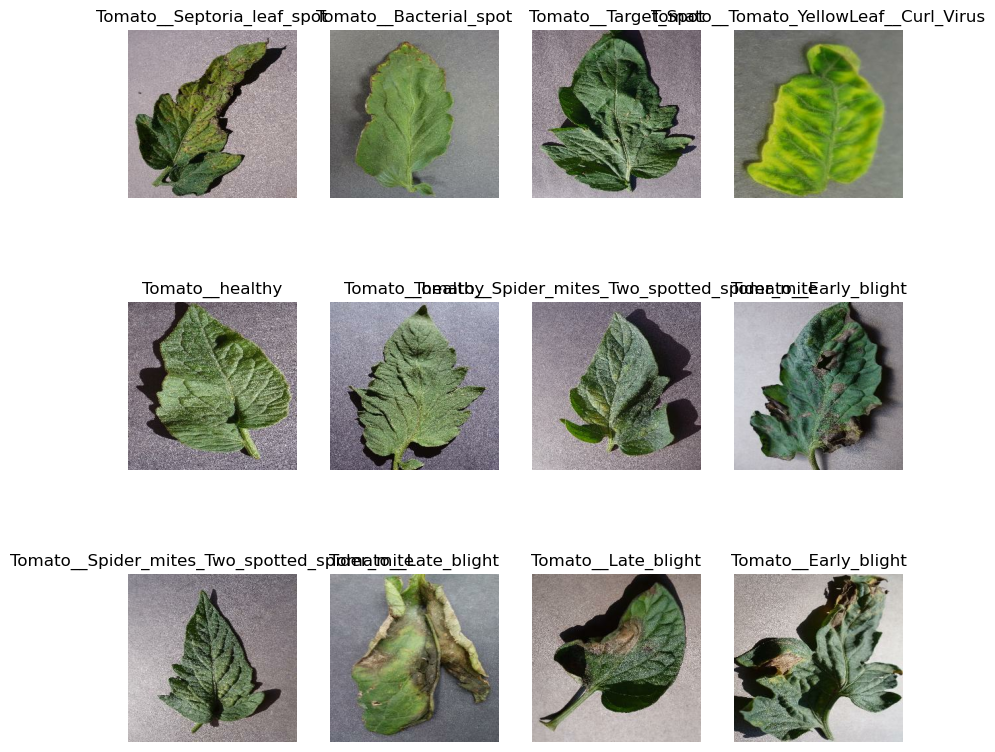

In [9]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for idx in range(12):
        ax = plt.subplot(3, 4, idx+1)
        plt.imshow(image_batch[idx].numpy().astype("uint8"))
        plt.title(class_names[label_batch[idx]])
        plt.axis("off")

In [10]:
len(dataset)

501

In [11]:
# 80% => training  - 20% => 10% validation, 10% test

In [12]:
train_size = 0.8
train_size = int(len(dataset) * train_size)
train_size

400

In [13]:
train_ds = dataset.take(train_size)
len(train_ds)

400

In [14]:
test_ds = dataset.skip(train_size)
len(test_ds)

101

In [15]:
val_size=0.1
len(dataset)*val_size
val_size = int(len(dataset) * val_size)
val_size

50

In [16]:
val_ds = test_ds.take(val_size)
len(val_ds)

50

In [17]:
test_ds=test_ds.skip(val_size)
len(test_ds)

51

In [18]:
def dataset_train_test_val_split(ds, train_pc=0.8, validation_pc=0.1, test_pc=0.1, shuffle=True, shuffle_size=10000):
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    ds_size = len(ds)
    train_size = int(train_pc * ds_size)
    validation_size = int(validation_pc * ds_size)
    
    train  = ds.take(train_size)
    validation  = ds.skip(train_size).take(validation_size)
    test  = ds.skip(train_size).skip(val_size)

    return train, validation, test                             

In [19]:
train_ds, val_ds, test_ds = dataset_train_test_val_split(dataset)

In [20]:
print(f"Train-ds length: {len(train_ds)}, Validation-ds length: {len(val_ds)} Test-ds length {len(test_ds)}")

Train-ds length: 400, Validation-ds length: 50 Test-ds length 51


In [21]:
# Cache -keeps the dataset elements in memory, Shuffle -  ensure data is randomly ordered across epochs, Prefetch - overlaps data preprocessing and model execution. While the GPU is training on the current batch, the CPU is already preparing the next batch in the background

In [22]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
#to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). 

resize_rescale_layer = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [24]:
#Data Augmentation helps when we have less data, it boosts the accuracy of model by adding additional data( in this case image rotation, flipped images)

data_augmentation_layer = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [25]:
print(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

32 256 256 3


In [26]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10  # num of labels

model = models.Sequential([
    # 1. The Input shape MUST come first in the list
    layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    # 2. Then your preprocessing layers
    resize_rescale_layer,
    data_augmentation_layer,
    # 3. Then your Convolutions
    layers.Conv2D(32, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size= (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size= (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    # rest of the layers
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(n_classes, activation="softmax"),
])

## In modern Keras (2026 standards), if you define layers.Input(shape=...) inside your Sequential list, 
## the model builds itself automatically the moment it is initialized.

# build not required
## model.build(input_shape=input_shape)

In [27]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 278,346 (1.06 MB)

 Trainable params: 278,346 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

EPOCHS

10

In [29]:
train_history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 219s 536ms/step - accuracy: 0.4041 - loss: 1.6483 - val_accuracy: 0.5031 - val_loss: 1.5615
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 217s 543ms/step - accuracy: 0.6951 - loss: 0.8759 - val_accuracy: 0.5263 - val_loss: 1.7740
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 213s 532ms/step - accuracy: 0.7841 - loss: 0.6086 - val_accuracy: 0.6744 - val_loss: 0.9253
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 214s 535s/step - accuracy: 0.8315 - loss: 0.4857 - val_accuracy: 0.8138 - val_loss: 0.6025
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 215s 537ms/step - accuracy: 0.8648 - loss: 0.3912 - val_accuracy: 0.7781 - val_loss: 0.7259
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 210s 526ms/step - accuracy: 0.8754 - loss: 0.3550 - val_accuracy: 0.7556 - val_loss: 0.8961
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 212s 529ms/step - accuracy: 0.8888 - loss: 0.3107 - val_accuracy: 0.7406 - val_loss: 1.0974
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 332s 830ms/step - accuracy: 0.9021 - 

In [30]:
scores = model.evaluate(test_ds)
scores

51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - accuracy: 0.8450 - loss: 0.4761


[0.476108580827713, 0.844975471496582]

In [31]:
train_history

In [32]:
train_history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [33]:
train_history.history["accuracy"]

[0.4041406214237213,
 0.6950781345367432,
 0.7841406464576721,
 0.8314843773841858,
 0.8647656440734863,
 0.8753906488418579,
 0.8888280987739563,
 0.9021093845367432,
 0.9166406393051147,
 0.9182812571525574]

In [34]:
len(train_history.history["accuracy"])

10

In [35]:
acc = train_history.history["accuracy"]
val_acc = train_history.history["val_accuracy"]
val_acc

[0.503125011920929,
 0.5262500047683716,
 0.6743749976158142,
 0.8137500286102295,
 0.778124988079071,
 0.7556250095367432,
 0.7406250238418579,
 0.8500000238418579,
 0.7806249856948853,
 0.8481249809265137]

In [36]:
loss = train_history.history["loss"]
val_loss = train_history.history["val_loss"]
val_loss

[1.5615168809890747,
 1.7739622592926025,
 0.9252732992172241,
 0.6024965047836304,
 0.7258725762367249,
 0.8961195349693298,
 1.0974452495574951,
 0.5059731602668762,
 0.7462727427482605,
 0.4230041205883026]

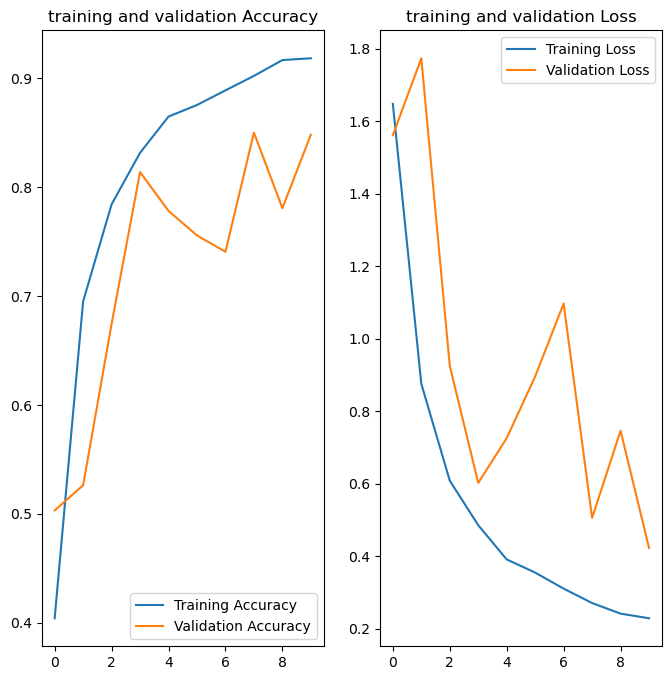

In [37]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label="Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("training and validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label="Training Loss")
plt.plot(range(EPOCHS), val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("training and validation Loss")
plt.show()


In [38]:
## Evaluate

image - 5 label: 8
actual label: Tomato__Tomato_mosaic_virus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
predition [2.2555367e-10 3.0371170e-06 3.9946030e-06 7.4153531e-06 1.4471025e-04
 1.6251928e-04 8.6351793e-05 2.7247529e-06 9.9957705e-01 1.2259617e-05]
np.argmax 8
predicted label: Tomato__Tomato_mosaic_virus


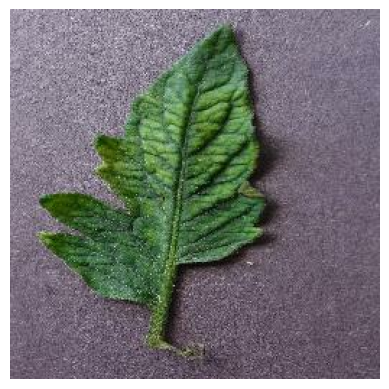

In [42]:
import numpy as np
img_ind = 5
for image_batch, label_batch in test_ds.take(1):
    
    image = image_batch[img_ind].numpy().astype("uint8")
    label = label_batch[img_ind].numpy()

    print(f"image - {img_ind} label: {label}")
    print("actual label:", class_names[label])
    
    plt.imshow(image)
    plt.axis("off")
    
    prediction = model.predict(image_batch)
    print("predition", prediction[img_ind])
    print("np.argmax", np.argmax(prediction[img_ind]))
    print("predicted label:",class_names[np.argmax(prediction[img_ind])])
    

In [43]:
def predict(model, img):
    # 1. Convert image to array
    # If img is already a tensor, we convert to numpy; if it's a PIL image, use img_to_array
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    
    # 2. Add batch dimension: (Height, Width, Channel) -> (1, Height, Width, Channel)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

### Plot images with predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


2026-02-17 20:33:45.327093: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


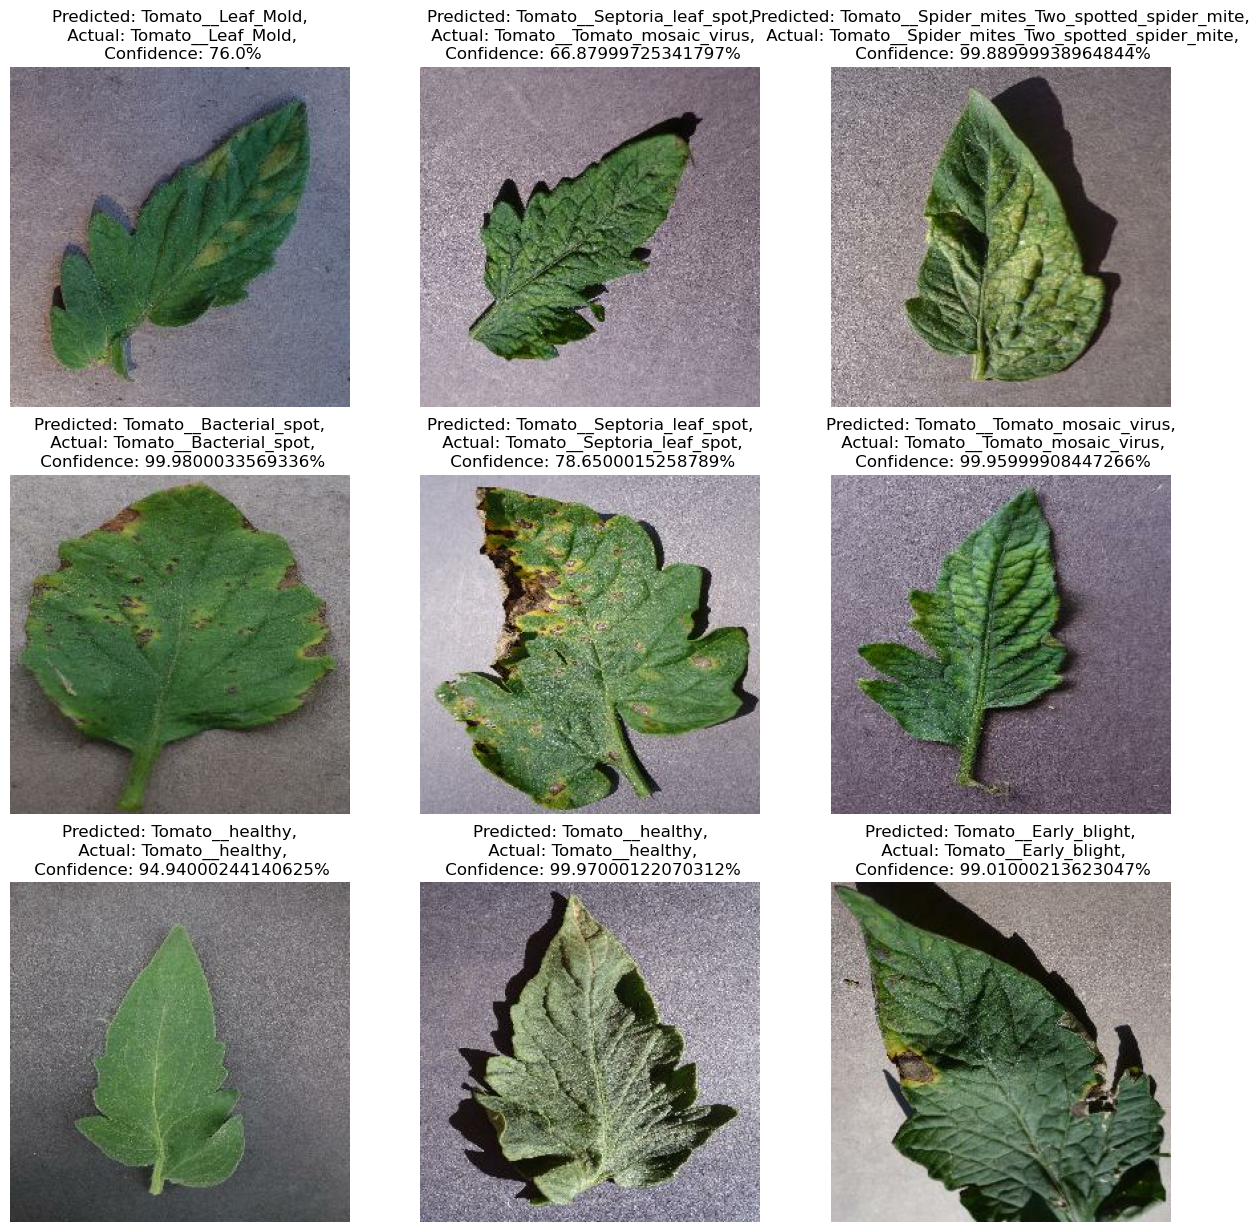

In [44]:
plt.figure(figsize=(15, 15))
# take(1)  -- first batch which will be 32 images.
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_label, confidence = predict(model, images[i].numpy())
        actual_label = class_names[labels[i]] 
        
        plt.title(f"Predicted: {predicted_label},\n Actual: {actual_label},\n Confidence: {confidence}%")
        plt.axis("off")

### Save Model

In [45]:
import os

model_path = "../saved_models"

if not os.path.exists(model_path):
    os.makedirs(model_path)

existing_versions = [
    int(f.split('.')[0]) 
    for f in os.listdir(model_path) 
    if f.split('.')[0].isdigit() and f.endswith('.keras')
]

model_version = max(existing_versions + [0]) + 1
print("existing_versions", existing_versions, model_version)
file_path = f"{model_path}/{model_version}.keras"
file_path

existing_versions [2, 1] 3


'../saved_models/3.keras'

In [46]:
# saved as {version}.keras  eg : 1.keras
model.save(file_path)